In [1]:
from __future__ import division
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
from PIL import Image
import astra
from src.projections_generator.project_2D import *

<h4>Create 2D phantom</h4>

Original phantom


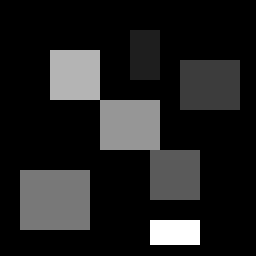

In [2]:
img_width, img_height = 256, 256

# create a simple phantom
phantom_data = np.full(fill_value=0,shape=(img_width, img_height))
phantom_data[30:80, 130: 160] = 30 # top right, darkest
phantom_data[60:110, 180:240] = 60  # top right, brighter of the two
phantom_data[150:200, 150:200] = 90  # bottom right, gray
phantom_data[170:230, 20:90] = 120  # bottom left one
phantom_data[100:150, 100:160] = 150  # middle one
phantom_data[50:100, 50:100] = 180  # top left
phantom_data[220:245,150:200] = 255 # bottom right, brigh white
phantom_data = phantom_data.astype(np.uint8)
print("Original phantom")
Image.fromarray(phantom_data)

<h4>Creating phantom volume and add to astra wrapper</h4>

In [3]:
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=phantom_data)

<h4>Create projections</h4>

In [4]:
n_projections = 180
detector_rows = img_width
detector_cols = img_height
detector_pixel_size = 1.05

angles = np.linspace(0, 2*np.pi, n_projections)
proj_geom = astra.create_proj_geom('parallel', detector_pixel_size, detector_rows, angles)
projector = astra.create_projector('line', proj_geom, vol_geom)
proj_id, projections = astra.creators.create_sino(phantom_id, projector)

In [5]:
projections.shape

(180, 256)

In [6]:
"""output_dir = 'dataset/'

# Save projections.
if not isdir(output_dir):
    mkdir(output_dir)
projections = np.round(projections * 65535).astype(np.uint8)
for i in range(n_projections):
    projection = projections[i]
    with get_writer(join(output_dir, 'proj%04d.png' %i)) as writer:
        writer.append_data(projection, {'compress': 9})"""

"output_dir = 'dataset/'\n\n# Save projections.\nif not isdir(output_dir):\n    mkdir(output_dir)\nprojections = np.round(projections * 65535).astype(np.uint8)\nfor i in range(n_projections):\n    projection = projections[i]\n    with get_writer(join(output_dir, 'proj%04d.png' %i)) as writer:\n        writer.append_data(projection, {'compress': 9})"

In [7]:
id, projs = project_from_2D(phantom_data,180,1.05, save_dir='test')

In [8]:
projs[150]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       172, 242,  55, 124, 194,   7,  76, 145, 215,  28,  98, 167, 236,
        49, 118, 188,   2,  70, 139, 210,  22,  91, 161, 230, 107, 141,
       195, 250,  47, 102, 156, 210,   8,  62, 116, 170, 225,  24,  76,
       128,  32, 217, 150,  79,  10, 198, 127,  60, 246, 176, 107,  38,
       225, 156,  87,  18, 203, 134,  65, 252, 183, 113,  43, 230,  68,
        12, 228, 189, 150, 111,  72,  33, 249,  71, 140, 208,  24,  93,
       162,   9, 132,   0, 163, 247,  75, 159, 244,  74, 156, 243,  71,
       154, 241,  69, 152,  10,  78, 146, 214,  28,  98, 166, 237, 172,
       130,  92,  88,  36, 236, 182, 127,  72,  17,  44, 139, 232,  70,
       169,  46, 176,  54, 188,  66, 198,  75, 208,  84, 216,  94, 226,
       102,  74, 155, 233,  56, 134,  90, 182,  20, 114, 207,  43, 137,
       169, 115,  61,   6, 207, 154, 100,  44, 248, 192, 138,  8